# Part 1: Data Ingestion


> - This demo works with the online feature store, which is currently not part of the Open Source default deployment.

This demo showcases financial fraud prevention and using the MLRun feature store to define complex features that help identify fraud. Fraud prevention specifically is a challenge as it requires processing raw transaction and events in real-time and being able to quickly respond and block transactions before they occur.

To address this, we create a development pipeline and a production pipeline. Both pipelines share the same feature engineering and model code, but serve data very differently. Furthermore, we automate the data and model monitoring process, identify drift and trigger retraining in a CI/CD pipeline. This process is described in the diagram below:

![Feature store demo diagram - fraud prevention](./images/feature_store_demo_diagram.png)

The raw data is described as follows:

| TRANSACTIONS                                                                    || &#x2551; |USER EVENTS                                                                           || 
|-----------------|----------------------------------------------------------------|----------|-----------------|----------------------------------------------------------------|
| **age**         | age group value 0-6. Some values are marked as U for unknown   | &#x2551; | **source**      | The party/entity related to the event                          |
| **gender**      | A character to define the gender                               | &#x2551; | **event**       | event, such as login or password change                        |
| **zipcodeOri**  | ZIP code of the person originating the transaction             | &#x2551; | **timestamp**   | The date and time of the event                                 |
| **zipMerchant** | ZIP code of the merchant receiving the transaction             | &#x2551; |                 |                                                                |
| **category**    | category of the transaction (e.g., transportation, food, etc.) | &#x2551; |                 |                                                                |
| **amount**      | the total amount of the transaction                            | &#x2551; |                 |                                                                |
| **fraud**       | whether the transaction is fraudulent                          | &#x2551; |                 |                                                                |
| **timestamp**   | the date and time in which the transaction took place          | &#x2551; |                 |                                                                |
| **source**      | the ID of the party/entity performing the transaction          | &#x2551; |                 |                                                                |
| **target**      | the ID of the party/entity receiving the transaction           | &#x2551; |                 |                                                                |
| **device**      | the device ID used to perform the transaction                  | &#x2551; |                 |                                                                |

This notebook introduces how to **Ingest** different data sources to the **Feature Store**.

The following FeatureSets will be created:
- **Transactions**: Monetary transactions between a source and a target.
- **Events**: Account events such as account login or a password change.
- **Label**: Fraud label for the data.

By the end of this tutorial you’ll learn how to:

- Create an ingestion pipeline for each data source.
- Define preprocessing, aggregation and validation of the pipeline.
- Run the pipeline locally within the notebook.
- Launch a real-time function to ingest live data.
- Schedule a cron to run the task when needed.

In [1]:
project_name = 'fraud-demo'

In [2]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2023-01-25 09:12:48,515 [info] Created and saved project fraud-demo-dani: {'from_template': None, 'overwrite': False, 'context': './', 'save': True}
> 2023-01-25 09:12:48,517 [info] created project fraud-demo and saved in MLRun DB


## Step 1 - Fetch, Process and Ingest our datasets

## 1.1 - Transactions

### Transactions

In [3]:
# Helper functions to adjust the timestamps of our data
# while keeping the order of the selected events and
# the relative distance from one event to the other

def date_adjustment(sample, data_max, new_max, old_data_period, new_data_period):
    '''
        Adjust a specific sample's date according to the original and new time periods
    '''
    sample_dates_scale = ((data_max - sample) / old_data_period)
    sample_delta = new_data_period * sample_dates_scale
    new_sample_ts = new_max - sample_delta
    return new_sample_ts

def adjust_data_timespan(dataframe, timestamp_col='timestamp', new_period='2d', new_max_date_str='now'):
    '''
        Adjust the dataframe timestamps to the new time period
    '''
    # Calculate old time period
    data_min = dataframe.timestamp.min()
    data_max = dataframe.timestamp.max()
    old_data_period = data_max-data_min
    
    # Set new time period
    new_time_period = pd.Timedelta(new_period)
    new_max = pd.Timestamp(new_max_date_str)
    new_min = new_max-new_time_period
    new_data_period = new_max-new_min
    
    # Apply the timestamp change
    df = dataframe.copy()
    df[timestamp_col] = df[timestamp_col].apply(lambda x: date_adjustment(x, data_max, new_max, old_data_period, new_data_period))
    df[timestamp_col].astype("datetime64[s]")
    return df

In [4]:
import pandas as pd

# Fetch the transactions dataset from the server
transactions_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# use only first 50k
transactions_data = transactions_data.sort_values(by='source', axis=0)[:50000]

# Adjust the samples timestamp for the past 2 days
transactions_data = adjust_data_timespan(transactions_data, new_period='2d')

# logging the data
project.log_dataset('transactions_data', transactions_data, format='csv')

# Preview
transactions_data.head(3)

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
184435,63,5,M,28007,28007,es_transportation,72.84,0,2023-01-24 23:25:15.001587510,C1000148617,M1823072687,2f13bbd87b9f42f98f5f3fce05890c82
333175,108,5,M,28007,28007,es_transportation,23.58,0,2023-01-23 22:12:09.276967113,C1000148617,M1823072687,2f13bbd87b9f42f98f5f3fce05890c82
451032,141,5,M,28007,28007,es_transportation,4.31,0,2023-01-25 05:57:24.766019439,C1000148617,M348934600,741ccdad2743422c98939329976a9c06


### Transactions - Create a FeatureSet and Preprocessing Pipeline
Create the FeatureSet (data pipeline) definition for the **credit transaction processing** which describes the offline/online data transformations and aggregations.<br>
The feature store will automatically add an offline `parquet` target and an online `NoSQL` target by using `set_targets()`.

The data pipeline consists of:

* **Extracting** the data components (hour, day of week)
* **Mapping** the age values
* **One hot encoding** for the transaction category and the gender
* **Aggregating** the amount (avg, sum, count, max over 2/12/24 hour time windows)
* **Aggregating** the transactions per category (over 14 days time windows)
* **Writing** the results to **offline** (Parquet) and **online** (NoSQL) targets 

In [5]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

In [6]:
# Define the transactions FeatureSet
transaction_set = fstore.FeatureSet("transactions", 
                                    entities=[fstore.Entity("source")], 
                                    timestamp_key='timestamp', 
                                    description="transactions feature set",
                                    engine='spark')

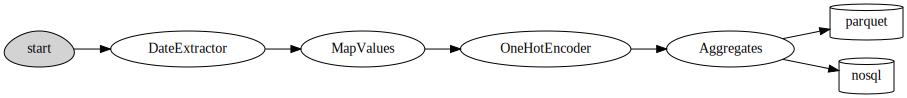

In [7]:
# Define and add value mapping
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(transactions_data.gender.unique())}

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour','month'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['12h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['count'], windows=['14d'], period='1d')

# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

### Transactions - Ingestion

When running with a Spark operator, the MLRun execution details are returned, allowing tracking of the job’s status and results.
Spark operator ingestion is always executed remotely.

The cell below should be executed only once to build the spark job image before running the first ingest. It may take a few minutes to prepare the image.

In [8]:
from mlrun.runtimes import RemoteSparkRuntime
RemoteSparkRuntime.deploy_default_image()

> 2023-01-25 09:13:04,744 [info] running build to add mlrun package, set with_mlrun=False to skip if its already in the image
> 2023-01-25 09:13:05,083 [info] Started building image: .remote-spark-default-image
INFO[0000] Retrieving image manifest datanode-registry.iguazio-platform.app.vmdev94.lab.iguazeng.com:80/iguazio/shell:3.5.3-b318.20230119151021 
INFO[0000] Retrieving image datanode-registry.iguazio-platform.app.vmdev94.lab.iguazeng.com:80/iguazio/shell:3.5.3-b318.20230119151021 from registry datanode-registry.iguazio-platform.app.vmdev94.lab.iguazeng.com:80 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest datanode-registry.iguazio-platform.app.vmdev94.lab.iguazeng.com:80/iguazio/shell:3.5.3-b318.20230119151021 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Building stage 'datanode-registry.iguazio-platform.app.vmdev94.lab.iguazeng.com:80/iguazio/shell:3.5

In [9]:
#mlrun: start-code

from mlrun.feature_store.api import ingest
def ingest_handler(context):
    ingest(mlrun_context=context) # The handler function must call ingest with the mlrun_context
    
# mlrun: end-code

In [10]:
function = mlrun.code_to_function(name='transactions_func', kind='spark', handler="ingest_handler")

function.with_driver_requests(cpu="1000m", mem="4G")
function.with_driver_limits(cpu="1000")
function.with_executor_requests(cpu="500m", mem="2G")
function.with_executor_limits(cpu="500m")
function.spec.replicas = 3
function.with_igz_spark()
function.spec.use_default_image = True

run_config = fstore.RunConfig(function=function, local=False)

In [ ]:
from mlrun.datastore.sources import CSVSource

# Creating our partitioned csv source
transaction_source = CSVSource("flow1_source", path=project.get_artifact('transactions_data').target_path)

# Ingest our transactions dataset through our defined pipeline
fstore.ingest(transaction_set, transaction_source, run_config=run_config, overwrite=True)

> 2023-01-25 09:18:34,065 [info] starting run transactions-ingest uid=777c75df7c6b4b7a9c6e4d95635de8ae DB=http://mlrun-api:8080
++ id -u
+ myuid=1000
++ id -g
+ mygid=1000
+ set +e
++ getent passwd 1000
+ uidentry=iguazio:x:1000:1000::/igz:/bin/bash
+ set -e
+ '[' -z iguazio:x:1000:1000::/igz:/bin/bash ']'
+ SPARK_CLASSPATH=':/spark/jars/*'
+ env
+ grep SPARK_JAVA_OPT_
+ sort -t_ -k4 -n
+ sed 's/[^=]*=\(.*\)/\1/g'
+ readarray -t SPARK_EXECUTOR_JAVA_OPTS
+ '[' -n '' ']'
+ '[' -z ']'
+ '[' -z ']'
+ '[' -n /hadoop ']'
+ '[' -z '' ']'
++ /hadoop/bin/hadoop classpath
+ export 'SPARK_DIST_CLASSPATH=/hadoop/etc/hadoop:/hadoop/share/hadoop/common/lib/*:/hadoop/share/hadoop/common/*:/hadoop/share/hadoop/hdfs:/hadoop/share/hadoop/hdfs/lib/*:/hadoop/share/hadoop/hdfs/*:/hadoop/share/hadoop/mapreduce/*:/hadoop/share/hadoop/yarn:/hadoop/share/hadoop/yarn/lib/*:/hadoop/share/hadoop/yarn/*:/hadoop/share/hadoop/tools/lib/hadoop-aws-3.3.1.jar:/hadoop/share/hadoop/tools/lib/aws-java-sdk-bundle-1.11.901.

After performing the ingestion process, you will be able to see all the different features that were created with the help of the UI, as you can see in the image below

![Features Catalog - fraud prevention](./images/features-catalog-transaction.png)

In [21]:
transaction_set.to_dataframe()

,source,timestamp,_c0,step,age,zipcodeOri,zipMerchant,amount,fraud,target,...,es_barsandrestaurants_count_14d,es_tech_count_14d,es_sportsandtoys_count_14d,es_wellnessandbeauty_count_14d,es_hyper_count_14d,es_fashion_count_14d,es_home_count_14d,es_contents_count_14d,es_travel_count_14d,es_leisure_count_14d
0,C1000148617,2023-01-23 10:00:00,323447,105,5,28007,28007,4.64,0,M1823072687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C100045114,2023-01-23 10:00:00,448323,140,4,28007,28007,59.52,0,M348934600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C1002759277,2023-01-23 10:00:00,384109,122,1,28007,28007,39.65,0,M1823072687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C1004300450,2023-01-23 10:00:00,433885,136,4,28007,28007,2.23,0,M1823072687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C1005126300,2023-01-23 10:00:00,372213,119,4,28007,28007,29.02,0,M1823072687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125973,C1187799344,2023-02-08 00:00:00,176188,61,3,28007,28007,31.21,0,M1823072687,...,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0
125974,C1187979419,2023-02-08 00:00:00,124869,44,2,28007,28007,3.40,0,M209847108,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
125975,C1188590334,2023-02-08 00:00:00,449851,140,6,28007,28007,16.02,0,M1823072687,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
125976,C1189231170,2023-02-08 00:00:00,87663,32,3,28007,28007,35.51,0,M1823072687,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0


## 1.2 - User Events

### User Events - Fetching

In [20]:
# Fetch our user_events dataset from the server
user_events_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', 
                               index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Adjust to the last 2 days to see the latest aggregations in our online feature vectors
user_events_data = adjust_data_timespan(user_events_data, new_period='2d')

# Preview
user_events_data.head(3)

,source,event,timestamp
0,C1974668487,details_change,2023-01-24 19:49:18.023360086
1,C1973547259,login,2023-01-24 22:50:52.280500508
2,C515668508,login,2023-01-24 19:23:58.561677302


### User Events - Create a FeatureSet and Preprocessing Pipeline

Now we will define the events feature set.
This is a pretty straight forward pipeline in which we only one hot encode the event categories and save the data to the default targets.

In [ ]:
user_events_set = fstore.FeatureSet("events",
                                    entities=[fstore.Entity("source")],
                                    timestamp_key='timestamp', 
                                    description="user events feature set",
                                    engine='spark')

In [ ]:
# Define and add value mapping
events_mapping = {'event': list(user_events_data.event.unique())}

# One Hot Encode
user_events_set.graph.to(OneHotEncoder(mapping=events_mapping))

# Add default (offline-parquet & online-nosql) targets
user_events_set.set_targets()

# Plot the pipeline so we can see the different steps
user_events_set.plot(rankdir="LR", with_targets=True)

### User Events - Ingestion

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("transaction_spark_function").getOrCreate()

# Ingestion of our newly created events feature set locally
events_df = fstore.ingest(user_events_set, user_events_data, spark_context=spark)

## Step 2 - Create a labels dataset for model training

### Label Set - Create a FeatureSet
This feature set contains the label for the fraud demo, it will be ingested directly to the default targets without any changes

In [ ]:
def create_labels(df):
    labels = df[['fraud','timestamp']].copy()
    labels = labels.rename(columns={"fraud": "label"})
    labels['timestamp'] = labels['timestamp'].astype("datetime64[ms]")
    labels['label'] = labels['label'].astype(int)
    return labels

In [ ]:
from mlrun.datastore import ParquetTarget
import os

# Define the "labels" feature set
labels_set = fstore.FeatureSet("labels", 
                           entities=[fstore.Entity("source")], 
                           timestamp_key='timestamp',
                           description="training labels",
                           engine="pandas")

labels_set.graph.to(name="create_labels", handler=create_labels)


# specify only Parquet (offline) target since its not used for real-time
target = ParquetTarget(name='labels',path=f'v3io:///projects/{project.name}/target.parquet')
labels_set.set_targets([target], with_defaults=False)
labels_set.plot(with_targets=True)

### Label Set - Ingestion

In [ ]:
# Ingest the labels feature set
labels_df = fstore.ingest(labels_set, transactions_data)
labels_df.head(3)

In [ ]:
stop here

## Step 3 - Deploy a real-time pipeline

When dealing with real-time aggregation, it's important to be able to update these aggregations in real-time.
For this purpose, we will create live serving functions that will update the online feature store of the `transactions` FeatureSet and `Events` FeatureSet.

Using MLRun's `serving` runtime, craetes a nuclio function loaded with our feature set's computational graph definition
and an `HttpSource` to define the HTTP trigger.

Notice that the implementation below does not require any rewrite of the pipeline logic.

## 3.1 - Transactions

### Transactions - Deploy our FeatureSet live endpoint

Using Storey engine to deploy the live endpoint.<br>
Storey is streaming library for real time event processing and feature extraction 

In [ ]:
transaction_set_deploy = fstore.FeatureSet("transactions", 
                                           entities=[fstore.Entity("source")], 
                                           timestamp_key='timestamp', 
                                           description="transactions feature set",
                                           engine='storey')

In [ ]:
# Create iguazio v3io stream and transactions push API endpoint
transaction_stream = f'v3io:///projects/{project.name}/streams/transaction'
transaction_pusher = mlrun.datastore.get_stream_pusher(transaction_stream)

In [ ]:
# Define the source stream trigger (use v3io streams)
# we will define the `key` and `time` fields (extracted from the Json message).
source = mlrun.datastore.sources.StreamSource(path=transaction_stream , key_field='source', time_field='timestamp')

# Deploy the transactions feature set's ingestion service over a real-time (Nuclio) serverless function
# you can use the run_config parameter to pass function/service specific configuration
transaction_set_endpoint = fstore.deploy_ingestion_service(featureset=transaction_set_deploy, source=source)

### Transactions - Test the feature set HTTP endpoint

By defining our `transactions` feature set we can now use MLRun and Storey to deploy it as a live endpoint, ready to ingest new data!

Using MLRun's `serving` runtime, we will create a nuclio function loaded with our feature set's computational graph definition and an `HttpSource` to define the HTTP trigger.

In [ ]:
import requests
import json

# Select a sample from the dataset and serialize it to JSON
transaction_sample = json.loads(transactions_data.sample(1).to_json(orient='records'))[0]
transaction_sample['timestamp'] = str(pd.Timestamp.now())
transaction_sample

In [ ]:
# Post the sample to the ingestion endpoint
requests.post(transaction_set_endpoint, json=transaction_sample).text

## 3.2 - User Events

### User Events - Deploy our FeatureSet live endpoint
Deploy the events feature set's ingestion service using the feature set and all the previously defined resources.

In [ ]:
user_events_set_deploy = fstore.FeatureSet("events",
                                    entities=[fstore.Entity("source")],
                                    timestamp_key='timestamp', 
                                    description="user events feature set",
                                    engine='storey')

In [ ]:
# Create iguazio v3io stream and transactions push API endpoint
events_stream = f'v3io:///projects/{project.name}/streams/events'
events_pusher = mlrun.datastore.get_stream_pusher(events_stream)

In [ ]:
# Define the source stream trigger (use v3io streams)
# we will define the `key` and `time` fields (extracted from the Json message).
source = mlrun.datastore.sources.StreamSource(path=events_stream , key_field='source', time_field='timestamp')

# Deploy the transactions feature set's ingestion service over a real-time (Nuclio) serverless function
# you can use the run_config parameter to pass function/service specific configuration
events_set_endpoint = fstore.deploy_ingestion_service(featureset=user_events_set_deploy, source=source)

### User Events - Test the feature set HTTP endpoint

In [ ]:
# Select a sample from the events dataset and serialize it to JSON
user_events_sample = json.loads(user_events_data.sample(1).to_json(orient='records'))[0]
user_events_sample['timestamp'] = str(pd.Timestamp.now())
user_events_sample

In [ ]:
# Post the sample to the ingestion endpoint
requests.post(events_set_endpoint, json=user_events_sample).text

## Done!

You've completed Part 1 of the data-ingestion with the feature store.
Proceed to [Part 2](02-create-training-model.ipynb) to learn how to train an ML model using the feature store data.